In [5]:
import numpy as np
from ecog_band.models import SVMBinClassifier, DecisionTreeBinClassifier, RandomForestBinClassifier, KNeighborsBinClassifier, GaussianNBBinClassifier
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import os
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from ecog_band.utils import *
from ecog_band.solver import Nfold_solver
import pandas as pd
# from ecog_band.datasetExcludeBand import CustomDatasetExcband
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import torch
from torch.utils import data as Data
from sklearn.model_selection import GridSearchCV,train_test_split
import torch.nn as nn
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle
import scipy.io as scio
import matplotlib.image as mpimg
import matplotlib as mpl


HS = 69
freq = 400
elec = 74
bands_list = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30),
    'gamma': (30, 70),
    'high gamma':(70,150),
    'else2':(150,min(freq/2, 300))
}
mpl.rcParams['font.size'] =10

# 使用全频段数据做binary classification

In [2]:
class ErpDataset(Data.Dataset):
    def __init__(self, HS, freq, elec):
        super().__init__()
        self.data = [] # 存Ecog数据，shape为（n_samples x n_features)
        self.labels = [] # 存label, shape=（n_samples），cue标记为0，read标记为1
        aligned_ecog_data_path = f'/public/DATA/overt_reading/aligned_ecogdata/HS{HS}/{freq}/allbands/'
        num_blocks = int(len(os.listdir(aligned_ecog_data_path)) / 4)
        print(num_blocks)
        cue_data, read_data = [], []
        for z in range(num_blocks):
            data_block_cue = np.load(os.path.join(aligned_ecog_data_path, f'{str(z)}_z_cue_data.npy'))
            data_block_read = np.load(os.path.join(aligned_ecog_data_path, f'{str(z)}_z_read_data.npy'))
            cue_data.append(data_block_cue[:, :, int(freq*0.5):])
            read_data.append(data_block_read[:, :, int(freq*0.5):])
        
        cue_data = np.vstack(cue_data)
        read_data = np.vstack(read_data)
        
        X=np.concatenate((cue_data[:, elec, :], read_data[:, elec, :]),axis=0)
        # X = X.reshape(-1, X.shape[1]*X.shape[2])

        y_cue=np.array([0]*cue_data.shape[0])
        y_read=np.array([1]*read_data.shape[0])
        y=np.concatenate((y_cue,y_read),axis=0)

        self.data = X
        self.labels = y

    def __len__(self):
        return len(self.data)
    
    def get_data_labels(self):
        return self.data, self.labels

    def __getitem__(self, idx):
        # Return a tuple of (data, label) and convert data to a PyTorch tensor
        # print(self.data.shape)
        return torch.tensor(abs(self.data[idx]), dtype=torch.float), torch.tensor(self.labels[idx])

In [3]:
data_loader = ErpDataset(HS, freq, elec)
data_all, labels_all = data_loader.get_data_labels()
print(f'data_shape: {data_all.shape}, data_label_shape:{labels_all.shape}')

X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=1/6, random_state=42, shuffle=True)
# svm = DecisionTreeBinClassifier()
svm = SVMBinClassifier()
svm.train(x_train=X_train, y_train=y_train)

y_pred = svm.evaluate(X_test=X_test, y_test=y_test)
band_acc = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set all_bands: {band_acc}")

6
data_shape: (720, 400), data_label_shape:(720,)
Accuracy on test set all_bands: 0.425


# 使用不同频段erp做binary classification

In [3]:
def get_band_ecogdata(HS, freq):
    '''
    加载已对齐的cue data和read data
    z_band_cue_data_all：所有band的cue data，存储格式为字典{band: data, band: data, ...}
    z_band_read_data_all：所有band的read data，存储格式为字典{band: data, band: data, ...}
    '''
    aligned_ecog_data_path = f'/public/DATA/overt_reading/aligned_ecogdata/HS{HS}/{freq}/bands/'
    num_blocks = int(len(os.listdir(aligned_ecog_data_path)) / 4)

    band_cue_data_all, band_read_data_all = {}, {}
    z_band_cue_data_all, z_band_read_data_all = {}, {}
    for band in bands_list:
        for b in range(num_blocks):
            data_block_cue = np.load(os.path.join(aligned_ecog_data_path, f'{str(b)}_cue_data.npy'), allow_pickle=True).item()
            data_block_read = np.load(os.path.join(aligned_ecog_data_path, f'{str(b)}_read_data.npy'), allow_pickle=True).item()
            z_block_cue = np.load(os.path.join(aligned_ecog_data_path, f'{str(b)}_z_cue_data.npy'), allow_pickle=True).item()
            z_block_read = np.load(os.path.join(aligned_ecog_data_path, f'{str(b)}_z_read_data.npy'), allow_pickle=True).item()

            band_cue = data_block_cue[band]
            band_read = data_block_read[band]
            z_band_cue = z_block_cue[band]
            z_band_read = z_block_read[band]
            band_cue_data_all.setdefault(band, []).append(band_cue)
            band_read_data_all.setdefault(band, []).append(band_read)
            z_band_cue_data_all.setdefault(band, []).append(z_band_cue)
            z_band_read_data_all.setdefault(band, []).append(z_band_read)
        
        # 每一个band 对应了6个block的数据
        # print(band_cue_data_all[band].shape)
        band_cue_data_all[band] = np.vstack(band_cue_data_all[band])
        _, _, shape1, shape2 = band_cue_data_all[band].shape
        band_cue_data_all[band] = band_cue_data_all[band].reshape(-1, shape1, shape2)
        band_read_data_all[band] = np.vstack(band_read_data_all[band]).reshape(-1, shape1, shape2)
        z_band_cue_data_all[band] = np.vstack(z_band_cue_data_all[band]).reshape(-1, shape1, shape2)
        z_band_read_data_all[band] = np.vstack(z_band_read_data_all[band]).reshape(-1, shape1, shape2)
        # print(band_cue_data_all[band].shape) # (360, 256, 380)
    return z_band_cue_data_all, z_band_read_data_all

In [4]:
class BandErpDataset(Data.Dataset):
    def __init__(self, z_band_cue_data_all, z_band_read_data_all, elec, band):
        '''z_band_cue_data_all, z_band_read_data_all为所有frequency bands的数据字典，每个band对应一个任务的所有trail的数据
        z_band_cue_data_all = {band : data(shape = n_trails, n_electrodes, n_timepoints)}
        '''
        super().__init__()
        self.data = [] # 存Ecog数据，shape为（n_samples x n_features)
        self.labels = [] # 存label, shape=（n_samples），cue标记为0，read标记为1
        # load aligned data and plot average signal
        cue_data = z_band_cue_data_all[band]
        read_data = z_band_read_data_all[band] 

        X=np.concatenate((cue_data[:, elec, :], read_data[:, elec, :]),axis=0)
        # X = X.reshape(-1, X.shape[1]*X.shape[2])

        y_cue=np.array([0]*cue_data.shape[0])
        y_read=np.array([1]*read_data.shape[0])
        y=np.concatenate((y_cue,y_read),axis=0)

        self.data = X
        self.labels = y

    def __len__(self):
        return len(self.data)
    
    def get_data_labels(self):
        return self.data, self.labels

    def __getitem__(self, idx):
        # Return a tuple of (data, label) and convert data to a PyTorch tensor
        # print(self.data.shape)
        return torch.tensor(abs(self.data[idx]), dtype=torch.float), torch.tensor(self.labels[idx])

data_shape: (720, 380), data_label_shape:(720,)
Accuracy on delta test set: 0.6333333333333333
data_shape: (720, 380), data_label_shape:(720,)
Accuracy on theta test set: 0.6
data_shape: (720, 380), data_label_shape:(720,)
Accuracy on alpha test set: 0.5333333333333333
data_shape: (720, 380), data_label_shape:(720,)
Accuracy on beta test set: 0.5166666666666667
data_shape: (720, 380), data_label_shape:(720,)
Accuracy on gamma test set: 0.5416666666666666
data_shape: (720, 380), data_label_shape:(720,)
Accuracy on high gamma test set: 0.6
data_shape: (720, 380), data_label_shape:(720,)
Accuracy on else2 test set: 0.43333333333333335


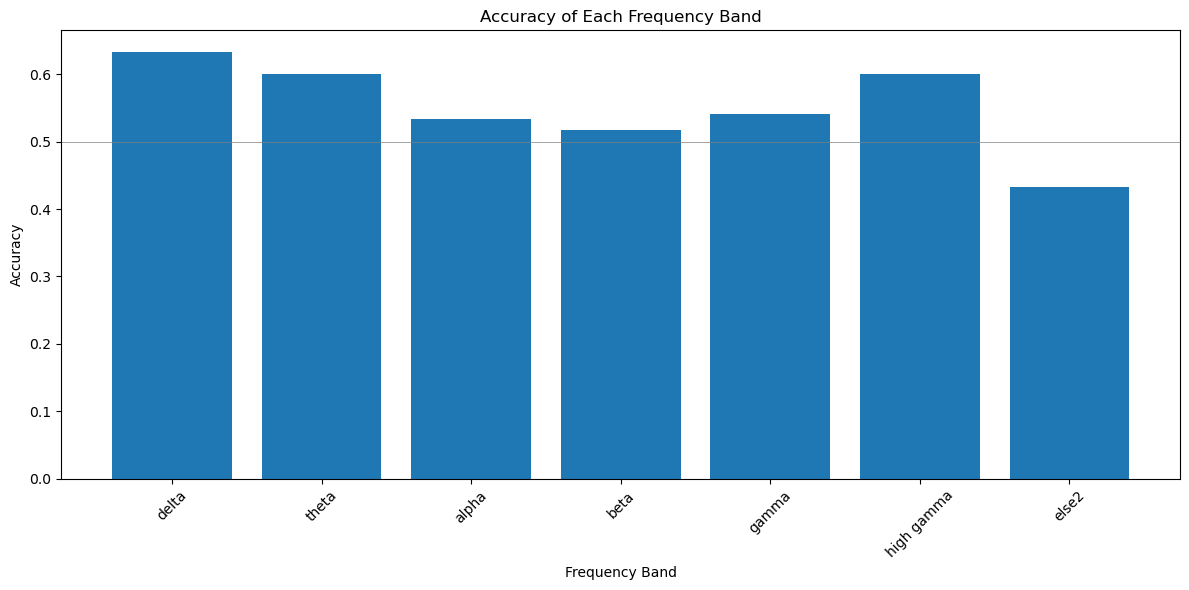

In [4]:
z_band_cue_data_all, z_band_read_data_all = get_band_ecogdata(HS, freq)
accuracyList = {}
for band in bands_list:
    data_loader = BandErpDataset(z_band_cue_data_all, z_band_read_data_all, elec, band)
    data_all, labels_all = data_loader.get_data_labels()
    print(f'data_shape: {data_all.shape}, data_label_shape:{labels_all.shape}')

    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=1/6, random_state=42, shuffle=True)
    # svm = DecisionTreeBinClassifier()
    svm = SVMBinClassifier()
    svm.train(x_train=X_train, y_train=y_train)

    y_pred = svm.evaluate(X_test=X_test, y_test=y_test)
    band_acc = accuracy_score(y_test, y_pred)
    accuracyList[band] = band_acc
    
    print(f"Accuracy on {band} test set: {band_acc}")
plt_band_acc(accuracyList)

# 计算不同frequency bands的所有电极的accuracy，并可视化到脑表面
## 1. 计算不同frequency bands的accuracy

In [17]:
def cal_bc_sig_HS_band(HS, freq, bands_list, elec_list, z_band_cue_data_all, z_band_read_data_all):
    bands_acc = {}
    for band in bands_list:
        band_elec_acc = []
        for i, elec in enumerate(elec_list):
            data_loader = BandErpDataset(z_band_cue_data_all, z_band_read_data_all, elec, band)
            data_all, labels_all = data_loader.get_data_labels()
            # print(f'data_shape: {data_all.shape}, data_label_shape:{labels_all.shape}')

            X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=1/6, random_state=42, shuffle=True)
            # svm = DecisionTreeBinClassifier()
            svm = SVMBinClassifier()
            svm.train(x_train=X_train, y_train=y_train)

            y_pred = svm.evaluate(X_test=X_test, y_test=y_test)
            elec_acc = accuracy_score(y_test, y_pred)
            band_elec_acc.append(elec_acc)
        bands_acc[band] = band_elec_acc
        print(f'Accuracy for HS{HS}-freq{freq} on {band} band is Done! acc_list={band_elec_acc}')
    
    return bands_acc
            


In [18]:
z_band_cue_data_all, z_band_read_data_all = get_band_ecogdata(HS, freq)
elec_list = [i for i in range(0, 256)]
HS_list = [69]
freq_list = [400]
save_acc_dir = f'/public/DATA/overt_reading/bands_acc'
os.makedirs(save_acc_dir, exist_ok=True)

for HS in HS_list:
    for freq in freq_list:
        save_acc_path = os.path.join(save_acc_dir, f'{HS}', f'{freq}')
        os.makedirs(save_acc_path, exist_ok=True)
        bands_acc = cal_bc_sig_HS_band(HS, freq, bands_list, elec_list, z_band_cue_data_all, z_band_read_data_all)
        np.save(os.path.join(save_acc_path, 'bands_acc.npy'), bands_acc)


Accuracy for HS69-freq400 on delta band is Done! acc_list=[0.43333333333333335, 0.4166666666666667, 0.4166666666666667, 0.4166666666666667, 0.4083333333333333, 0.425, 0.475, 0.55, 0.5583333333333333, 0.475, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.43333333333333335, 0.4666666666666667, 0.425, 0.425, 0.4083333333333333, 0.4166666666666667, 0.425, 0.4666666666666667, 0.45, 0.43333333333333335, 0.44166666666666665, 0.4166666666666667, 0.4083333333333333, 0.425, 0.4166666666666667, 0.4166666666666667, 0.44166666666666665, 0.44166666666666665, 0.425, 0.4166666666666667, 0.425, 0.4083333333333333, 0.43333333333333335, 0.48333333333333334, 0.5333333333333333, 0.55, 0.5166666666666667, 0.5333333333333333, 0.49166666666666664, 0.4666666666666667, 0.49166666666666664, 0.4583333333333333, 0.425, 0.425, 0.475, 0.4166666666666667, 0.45, 0.5333333333333333, 0.5833333333333334, 0.6166666666666667, 0.6166666666666667, 0.625, 0.6166666666666667, 0.575, 0.425, 0.425, 0.4166666666666667, 0.4333

In [19]:
save_acc_path = os.path.join(f'/public/DATA/overt_reading/bands_acc', f'{HS}', f'{freq}')
bands_acc = np.load('/public/DATA/overt_reading/bands_acc/69/400/bands_acc.npy', allow_pickle=True).item()
for band in bands_list:
    acc_mean = np.mean(bands_acc[band])
    print(f'{band} accuracy mean: {acc_mean}')

delta accuracy mean: 0.45693359375
theta accuracy mean: 0.46123046874999996
alpha accuracy mean: 0.4612630208333333
beta accuracy mean: 0.5198567708333333
gamma accuracy mean: 0.4641927083333333
high gamma accuracy mean: 0.45748697916666664
else2 accuracy mean: 0.4388997395833333


## 2. 将不同band的accuracy可视化到脑表面

In [2]:
def add_right_cax(ax, pad, width):
    '''
    在一个ax右边追加与之等高的cax.
    pad是cax与ax的间距.
    width是cax的宽度.
    '''
    axpos = ax.get_position()
    caxpos = mpl.transforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)

def plot_bands_acc_elecs_brain(HS, freq, band):
    path = '/public/DATA/overt_reading/'
    # 所有电极在不同频段的acc
    save_acc_path = os.path.join(f'/public/DATA/overt_reading/bands_acc', f'{HS}', f'{freq}')
    bands_acc = np.load(os.path.join(save_acc_path, 'bands_acc.npy'), allow_pickle=True).item()
    band_acc = bands_acc[band]
    # 数据加载
    subject_str = f"HS{HS}"
    xy = scio.loadmat(path + f"/elecs/All_elecs/{subject_str}_warped_elec_pos2D.mat")['elecmatrix']
    img = mpimg.imread(path + "/elecs/Brain2D/MNI152_brain2D.png")

    fig, ax = plt.subplots(figsize=(15,15))
    ax.imshow(img)
    
    x_coords, y_coords = [],[]
    values = []
    ax_ind = 0 
        
    for i, acc in enumerate(band_acc):
       
        # HS,elec = HS_elec_list[i].split("_")
        elec = i
        # xy = xy_all[f"HS{HS}"]
        x_coords.append(xy[elec][0])
        y_coords.append(xy[elec][1])
        values.append(acc)

        if acc > 0.5:    
            plt.text(xy[elec][0],xy[elec][1],f"{HS}_{elec}")
    
    im = plt.scatter(x_coords, y_coords, c=values, cmap='Reds', alpha = 0.7)

    plt.grid('off') 
    plt.axis('off')

    plt.xticks([])
    plt.yticks([])
    plt.title(f"Electrode accuracy for HS{HS}_{band}")
    cax = add_right_cax(ax, pad=0.02, width=0.02)
    cbar = fig.colorbar(im, cax=cax)
    plt.show()

    # # 额外设置
    # ax.grid('off')
    # ax.axis('off')
    # ax.set_xticks([])
    # ax.set_yticks([])
    # ax.set_title(f"Electrodes Distribution with Frequency Band Accuracy for HS{HS}", size=20)

    # plt.tight_layout(rect=[0, 0, 1, 0.9])
    # plt.savefig(f"/root/pp/covert-reading/Ecog_pretrain/figures/fig_acc_distri_HS{HS}_freq{freq}.pdf", dpi=1200)
    # plt.show()

In [ ]:
for band in bands_list:
    plot_bands_acc_elecs_brain(69, 400, band)